# Calibration measurement for readout of the quantum state of two qubits

[Course of Applied Quantum Systems, year 2023, student Petrillo Daniele P37000102]

In this notebook we analyse some calibration measurements produced during experiments of superconductive qubit state detection, in order to calibrate the detecting instrument and calculate its accuracy.

## Protocol background

The protocol used is called "*single-shot readout measurement*" and can be divided into 4 processes:

   1. Prepare the qubit by sending a microwave pulse of the right frequency corresponding to the excitation frequency of the qubit state (if needed);
   2. Send a pulsed (*readout*) signal with set power and frequency in order to resonate with the readout cavity (LC circuit) coupled with the qubit;
   3. Acquire the output (reflected or refracted) pulsed signal given back by the resonator;
   4. Analyse the received signal to determine the measured state of the qubit.

In this work, the protocol is executed in 4 different configurations of two qubits, namely q0 and q2:

- After preparing both qubits in the ground state i.e. |0⟩|0⟩;
- After preparing q0 in ground state and q2 in excited state i.e. |0⟩|1⟩;
- After preparing q0 in excited state and q2 in ground state i.e. |1⟩|0⟩;
- After preparing both qubits in the excited state i.e. |1⟩|1⟩.

The dataset proposed contains all the abovementioned measurements of **Real** (**I**) and **Imaginary** (**Q**) compontnents of the output signal.

In particular, the dataset is divided into two parts:

- *single shots*: each measurement is an actual (single) pulse coming back from the resonator;
- *averaged shots*:  each measurement is the average of 1000 single shots.

We pass now to the code part of this notebook, where we divide the analysis into four parts and make some considerations on the results.

In [166]:
# libraries needed for the notebook
import pandas as pd
import numpy as np
import h5py
import math
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from copy import deepcopy
from scipy.stats import norm
import seaborn as sn

These initial cells are used to read the dataset and modify it in order to make manipulations easier:

In [167]:
# converts the dataset in pandas dataframe 
def create_pd_df(path):
    y0 = np.array(h5py.File(path)["y0"])
    y1 = np.array(h5py.File(path)["y1"])
    y2 = np.array(h5py.File(path)["y2"])
    y3 = np.array(h5py.File(path)["y3"])
    df = pd.DataFrame(data=[y0,y1,y2,y3])
    df = df.T
    df.columns = ["y0", "y1", "y2", "y3"]
    return df

An example of the dataset structure is the following. 

Here we print the dataset for averaged mode and prepared state |0⟩|0⟩; y0 and y1 refer respectively to the real and imaginary component of the signal for qubit 0, while y2 and y3 the same for qubit 2:

In [168]:
df = pd.read_csv("Pandas_datasets\Averaged\Cal00_q0q2_avg1000_shot101.csv")
df

,y0,y1,y2,y3
0,0.104383,-0.025422,-0.052902,0.049106
1,0.105110,-0.022210,-0.054091,0.050378
2,0.103832,-0.022235,-0.052257,0.048934
3,0.102870,-0.026875,-0.050504,0.049110
4,0.103454,-0.023196,-0.052704,0.048886
...,...,...,...,...
96,0.103918,-0.024438,-0.052089,0.048290
97,0.104180,-0.021894,-0.052817,0.048430
98,0.103655,-0.022175,-0.052188,0.047482
99,0.104394,-0.021806,-0.052421,0.047055


To finish the preparation of the data we create a dictionary which will make manipulations easier:

In [169]:
df_averaged_00 = pd.read_csv("Pandas_datasets\Averaged\Cal00_q0q2_avg1000_shot101.csv")
df_averaged_01 = pd.read_csv("Pandas_datasets\Averaged\Cal01_q0q2_avg1000_shot101.csv")
df_averaged_10 = pd.read_csv("Pandas_datasets\Averaged\Cal10_q0q2_avg1000_shot101.csv")
df_averaged_11 = pd.read_csv("Pandas_datasets\Averaged\Cal11_q0q2_avg1000_shot101.csv")

df_single_00 = pd.read_csv("Pandas_datasets\Single-shot\Cal00_q0q2_avg1_shot760.csv")
df_single_01 = pd.read_csv("Pandas_datasets\Single-shot\Cal01_q0q2_avg1_shot760.csv")
df_single_10 = pd.read_csv("Pandas_datasets\Single-shot\Cal10_q0q2_avg1_shot760.csv")
df_single_11 = pd.read_csv("Pandas_datasets\Single-shot\Cal11_q0q2_avg1_shot760.csv")

dataset = {"avg":[[df_averaged_00, df_averaged_01], [df_averaged_10, df_averaged_11]], 
           "s-s":[[df_single_00, df_single_01], [df_single_10, df_single_11]]}

## Analysis 1: plot dataframes into I-Q graphs
In this section we are intersted in plotting the signals on a I-Q plane, in order to visualize the difference in response of a qubit between state |0⟩ and state |1⟩, while fixing the other (coupled) qubit to a given state (|0⟩ or |1⟩)

In [ ]:
# initializes the figure and axis for multiple plotting
def set_figure(nrows=2, ncols=2, pad=2, suptitle="", fontsize=15, y=1.03, size=7):
    fig, ax = plt.subplots(nrows,ncols)
    fig.tight_layout(pad=pad)
    fig.suptitle(suptitle, fontsize=fontsize, y=y)
    fig.set_size_inches(size,size)
    return fig, ax

In [131]:
# plots the 4 graphs in the same figure
def plot_4graphs(dataset, ax, mode):

    dataset[mode][0][0].plot(kind="scatter", label="q0 in |0⟩", x="y1", y="y0", color="red", title="q2 is in |0⟩", ax=ax[0,0])
    dataset[mode][1][0].plot(kind="scatter", label="q0 in |1⟩", x="y1", y="y0", color="green", xlabel="Q(V)", ylabel="I(V)", ax=ax[0,0])

    dataset[mode][0][1].plot(kind="scatter", label="q0 in |0⟩", x="y1", y="y0", color="red", title="q2 is in |1⟩", ax=ax[0,1])
    dataset[mode][1][1].plot(kind="scatter", label="q0 in |1⟩", x="y1", y="y0", color="green", xlabel="Q(V)", ylabel="I(V)", ax=ax[0,1])

    dataset[mode][0][0].plot(kind="scatter", label="q2 in |0⟩", x="y3", y="y2", color="red", title="q0 is in |0⟩", ax=ax[1,0])   
    dataset[mode][0][1].plot(kind="scatter", label="q2 in |1⟩", x="y3", y="y2", color="green", xlabel="Q(V)", ylabel="I(V)", ax=ax[1,0])

    dataset[mode][1][0].plot(kind="scatter", label="q2 in |0⟩", x="y3", y="y2", color="red", title="q0 is in |1⟩", ax=ax[1,1])
    dataset[mode][1][1].plot(kind="scatter", label="q2 in |1⟩", x="y3", y="y2", color="green", xlabel="Q(V)", ylabel="I(V)", ax=ax[1,1]) 

Visualization of IQ shots in average mode:

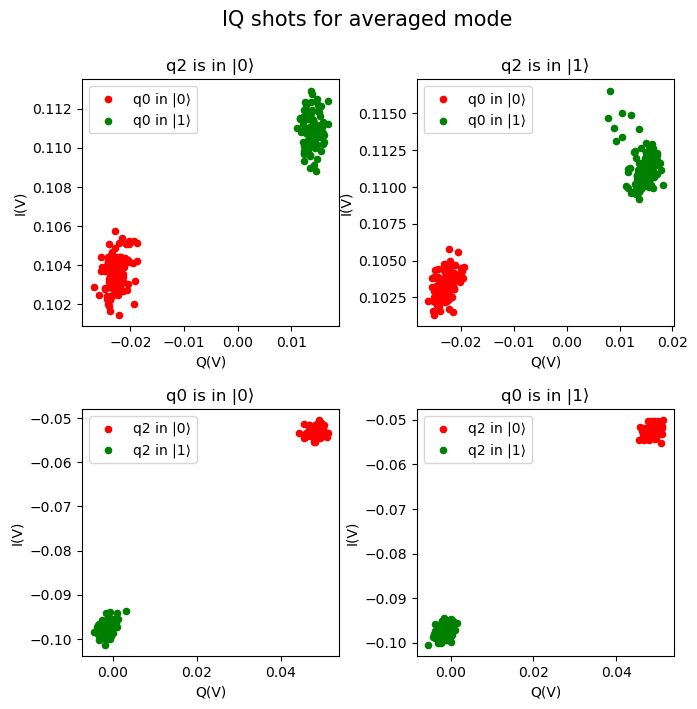

In [170]:
fig, ax = set_figure(suptitle="IQ shots for averaged mode")
plot_4graphs(dataset, ax, "avg")

Visualization of IQ shots in single-shot mode:

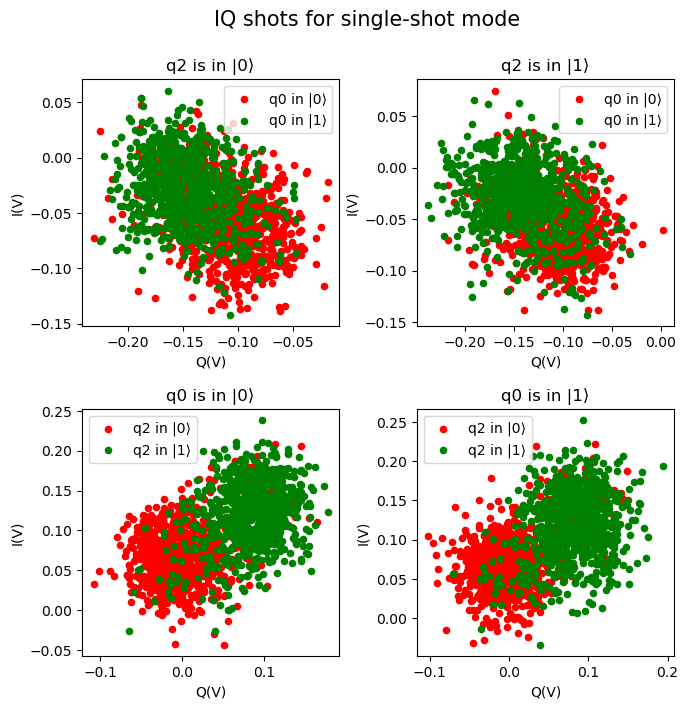

In [134]:
fig, ax = set_figure(suptitle="IQ shots for single-shot mode")
plot_4graphs(dataset, ax, "s-s")

Looking at the graphs, we can make some considerations:

- the voltage values for equal state of the qubit (images in the same row) are very similar, this is expected, since e.g. qubit 0 in state |0⟩ will give back the same voltage response regardless of the state of qubit 2 (unless they are heavily coupled);
  
- the two qubits have readout voltages of the same order of magnitude, again expected given that their fundamental frequency and the one of the resonators are aswell;
- the single-shot mode gives blobs of voltages significantly more spread out than the averaged mode, this is caused by the fact that all measurements are subjected to numerous sources of noise; the averaging operation in the average mode suppresses (but never completely) the *stochastic* noise factor (which here is the main one);
- at least the shots in average mode give a good separation between the two blobs corresponding to the two different states of the qubits, this means that we are able to distinguish the measured states (which is the ultimate aim of the measurement).

## Analysis 2: find centroids and radii of voltage blobs and rotate on a given axis

Since every measurement is really a blob of voltages, we want to find a way to characterize them; this will be done by finding the *centre* (*centroid*) of the blob and its *radius* (the average "spread" of the points). 

These two variables will identify each blob, and will be used to rotate the IQ plane until the two blobs corresponding to the ground and excited state of the qubit are aligned in one of the two axis (in our case, we'll align them on the Q axis).

### 2.1 Find centres of blobs and their radii
The centroid of each blob is calculated through a clustering technique, named **Kmeans**, while their radius is obtained as the average distance of a point from the centroid location.

In [171]:
# finds centroid and radius given a blob
def find_centroid_and_spreads(blob):
    km = KMeans(n_clusters=1, init="random", n_init=10,
                max_iter=300, tol=1e-04, random_state=42)
    y_km = km.fit_predict(blob)
    centroid = pd.DataFrame(km.cluster_centers_[0]).T
    centroid.columns = ["x","y"]
    radius = 0
    for i in range(blob.shape[0]):
        radius = radius + np.linalg.norm(centroid.values[0] - blob.iloc[i])
    inertia = radius / blob.shape[0]
    return centroid, inertia

In [196]:
# initializes dictionaries
def initialize_2x2dict(mode1,mode2):
    return {mode1:[[0, 0], [0, 0]], mode2:[[0, 0], [0, 0]]}

All the blobs are separated from the dataset (remember that each row of the dataset includes both measures for q0 and q2, while we now need them separated):

In [173]:
blobs_q0 = {"avg":[[df_averaged_00[["y1", "y0"]], df_averaged_01[["y1", "y0"]]], [df_averaged_10[["y1", "y0"]], df_averaged_11[["y1", "y0"]]]], 
           "s-s":[[df_single_00[["y1", "y0"]], df_single_01[["y1", "y0"]]], [df_single_10[["y1", "y0"]], df_single_11[["y1", "y0"]]]]}

blobs_q2 = {"avg":[[df_averaged_00[["y3", "y2"]], df_averaged_01[["y3", "y2"]]], [df_averaged_10[["y3", "y2"]], df_averaged_11[["y3", "y2"]]]], 
           "s-s":[[df_single_00[["y3", "y2"]], df_single_01[["y3", "y2"]]], [df_single_10[["y3", "y2"]], df_single_11[["y3", "y2"]]]]}

The centroids and radii (*inertias*) dictionaries are initialized:

In [139]:
centroids_q0 = initialize_2x2dict("avg","s-s")
inertias_q0 = initialize_2x2dict("avg","s-s")

centroids_q2 = initialize_2x2dict("avg","s-s")
inertias_q2 = initialize_2x2dict("avg","s-s")

Now we fill the dictionaries with calculated values:

In [ ]:
for mode in ["avg","s-s"]:
    for i in range(2):
        for j in range(2):

            centroids_q0[mode][i][j], inertias_q0[mode][i][j] = find_centroid_and_spreads(blobs_q0[mode][i][j])
            centroids_q2[mode][i][j], inertias_q2[mode][i][j] = find_centroid_and_spreads(blobs_q2[mode][i][j])

We're ready to plot the blobs with their *centroids* and *radii*.

In [175]:
# plots the centroids and radii
def plot_centroid_and_inertia_4graphs(centroids_q0, inertias_q0, centroids_q2, inertias_q2, ax, mode):
    
    q0 = centroids_q0[mode]
    q2 = centroids_q2[mode]

    radius_q0 = inertias_q0[mode]
    radius_q2 = inertias_q2[mode]

    q0[0][0].plot(kind="scatter", x="x", y="y", c="black", edgecolors="black", xlabel="Q(V)", ylabel="I(V)", label="centroid", ax=ax[0,0])
    q0[1][0].plot(kind="scatter", x="x", y="y", c="black", edgecolors="black", xlabel="Q(V)", ylabel="I(V)", ax=ax[0,0])
    ax[0][0].add_patch(plt.Circle(tuple(q0[0][0].values[0]), radius_q0[0][0], color="black", fill=False))
    ax[0][0].add_patch(plt.Circle(tuple(q0[1][0].values[0]), radius_q0[1][0], color="black", fill=False))

    q0[0][1].plot(kind="scatter", x="x", y="y", c="black", edgecolors="black", xlabel="Q(V)", ylabel="I(V)", label="centroid", ax=ax[0,1])
    q0[1][1].plot(kind="scatter", x="x", y="y", c="black", edgecolors="black", xlabel="Q(V)", ylabel="I(V)", ax=ax[0,1])
    ax[0][1].add_patch(plt.Circle(tuple(q0[0][1].values[0]), radius_q0[0][1], color="black", fill=False))
    ax[0][1].add_patch(plt.Circle(tuple(q0[1][1].values[0]), radius_q0[1][1], color="black", fill=False))

    q2[0][0].plot(kind="scatter", x="x", y="y", c="black", edgecolors="black", xlabel="Q(V)", ylabel="I(V)", label="centroid", ax=ax[1,0])
    q2[0][1].plot(kind="scatter", x="x", y="y", c="black", edgecolors="black", xlabel="Q(V)", ylabel="I(V)", ax=ax[1,0])
    ax[1][0].add_patch(plt.Circle(tuple(q2[0][0].values[0]), radius_q2[0][0], color="black", fill=False))
    ax[1][0].add_patch(plt.Circle(tuple(q2[0][1].values[0]), radius_q2[0][1], color="black", fill=False))

    q2[1][0].plot(kind="scatter", x="x", y="y", c="black", edgecolors="black", xlabel="Q(V)", ylabel="I(V)", label="centroid", ax=ax[1,1])
    q2[1][1].plot(kind="scatter", x="x", y="y", c="black", edgecolors="black", xlabel="Q(V)", ylabel="I(V)", ax=ax[1,1])
    ax[1][1].add_patch(plt.Circle(tuple(q2[1][0].values[0]), radius_q2[1][0], color="black", fill=False))
    ax[1][1].add_patch(plt.Circle(tuple(q2[1][1].values[0]), radius_q2[1][1], color="black", fill=False))

Plotting blobs for average mode:

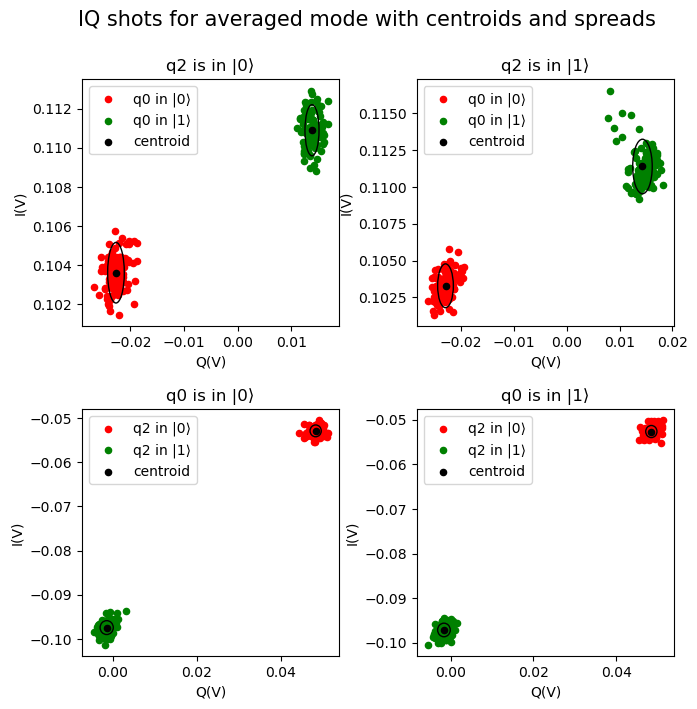

In [176]:
fig, ax = set_figure(suptitle="IQ shots for averaged mode with centroids and spreads")
plot_4graphs(dataset, ax, "avg")
plot_centroid_and_inertia_4graphs(centroids_q0, inertias_q0, centroids_q2, inertias_q2, ax, "avg")

Plotting blobs for single-shot mode:

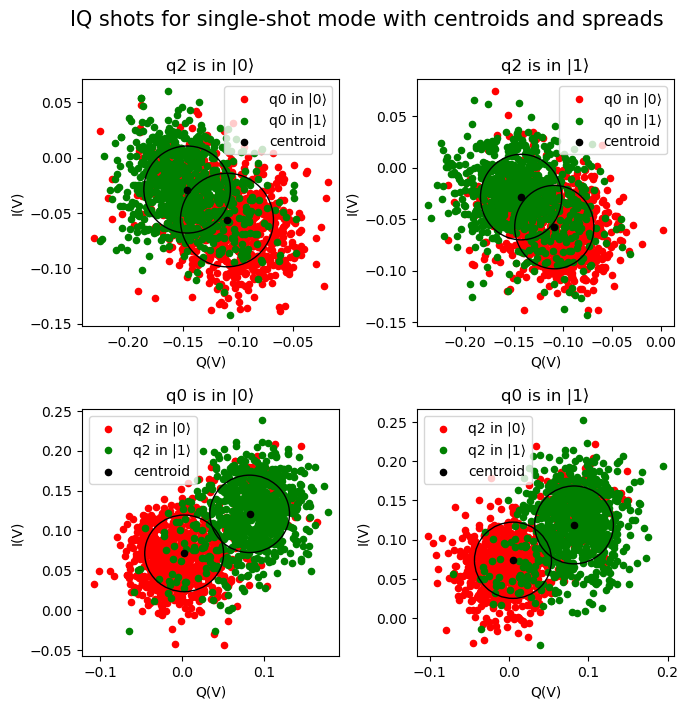

In [143]:
fig, ax = set_figure(suptitle="IQ shots for single-shot mode with centroids and spreads")
plot_4graphs(dataset, ax, "s-s")
plot_centroid_and_inertia_4graphs(centroids_q0, inertias_q0, centroids_q2, inertias_q2, ax, "s-s")

We see that, as expected, the single-shot measurements give significantly overlapped blobs, which gives a hint about their usability for state detection; on the other hand, averaged shots are highly localized.

### 2.2 Rotate the frame
Aligning the blobs basically results in the isolation of one of the two signal components, this can be useful for an easier detection of the state, when the considered variable changes between the two states (this depends on the choice of readout frequency used).

To align the two blobs corresponding to the two states, we do the following:
1. Find the angle between the segment that connects the two centroids and the the imaginary axis;
2. Build a rotation matrix for that specific angle;
3. Rotate all the points by multiplying the rotation matrix with the points vector.

In [177]:
# finds the rotation matrix between the two points
def find_rotation_matrix(point0, point1):

    x_0, y_0 = point0.values[0]
    x_1, y_1 = point1.values[0]
    d = np.linalg.norm(point0.values[0] - point1.values[0])
    sin = (y_1-y_0)/d
    cos = (x_1-x_0)/d
    matrix = np.array(((cos,sin), (-sin,cos)))
    return matrix

In [178]:
# rotates two blobs
def rotate_blobs(blob0, blob1, centroid0, centroid1):

    matrix = find_rotation_matrix(centroid0, centroid1)

    blob0_positions = np.array(blob0)
    blob1_positions = np.array(blob1)

    blob0_rotated = np.empty(shape=blob0.shape)
    blob1_rotated = np.empty(shape=blob1.shape)

    for i in range(blob0_positions.shape[0]):
        blob0_rotated[i] = matrix.dot(blob0_positions[i])

    for i in range(blob1_positions.shape[0]):
        blob1_rotated[i] = matrix.dot(blob1_positions[i])

    rotated_centroid0 = matrix.dot(centroid0.values[0])
    rotated_centroid1 = matrix.dot(centroid1.values[0])

    return blob0_rotated, blob1_rotated, rotated_centroid0, rotated_centroid1


We'll make a copy of the dataset and rotate all points:

In [179]:
# Rotate all the dataset (warning: very ugly)
dataset_rotated = deepcopy(dataset)
centroids_q0_rot = deepcopy(centroids_q0)
centroids_q2_rot = deepcopy(centroids_q2)

for mode in ["avg","s-s"]:
    
    q0_rotated_00, q0_rotated_10, centroid_q0_00, centroid_q0_10 = rotate_blobs(blobs_q0[mode][0][0], blobs_q0[mode][1][0], centroids_q0[mode][0][0], centroids_q0[mode][1][0])
    q0_rotated_01, q0_rotated_11, centroid_q0_01, centroid_q0_11 = rotate_blobs(blobs_q0[mode][0][1], blobs_q0[mode][1][1], centroids_q0[mode][0][1], centroids_q0[mode][1][1])
    q2_rotated_00, q2_rotated_01, centroid_q2_00, centroid_q2_01 = rotate_blobs(blobs_q2[mode][0][0], blobs_q2[mode][0][1], centroids_q2[mode][0][0], centroids_q2[mode][0][1])
    q2_rotated_10, q2_rotated_11, centroid_q2_10, centroid_q2_11 = rotate_blobs(blobs_q2[mode][1][0], blobs_q2[mode][1][1], centroids_q2[mode][1][0], centroids_q2[mode][1][1])

    dataset_rotated[mode][0][0]["y1"] = q0_rotated_00[:,0]
    dataset_rotated[mode][0][0]["y0"] = q0_rotated_00[:,1]
    dataset_rotated[mode][1][0]["y1"] = q0_rotated_10[:,0]
    dataset_rotated[mode][1][0]["y0"] = q0_rotated_10[:,1]
    centroids_q0_rot[mode][0][0]["x"] = centroid_q0_00[0]
    centroids_q0_rot[mode][0][0]["y"] = centroid_q0_00[1]
    centroids_q0_rot[mode][1][0]["x"] = centroid_q0_10[0]
    centroids_q0_rot[mode][1][0]["y"] = centroid_q0_10[1]

    dataset_rotated[mode][0][1]["y1"] = q0_rotated_01[:,0]
    dataset_rotated[mode][0][1]["y0"] = q0_rotated_01[:,1]
    dataset_rotated[mode][1][1]["y1"] = q0_rotated_11[:,0]
    dataset_rotated[mode][1][1]["y0"] = q0_rotated_11[:,1]
    centroids_q0_rot[mode][0][1]["x"] = centroid_q0_01[0]
    centroids_q0_rot[mode][0][1]["y"] = centroid_q0_01[1]
    centroids_q0_rot[mode][1][1]["x"] = centroid_q0_11[0]
    centroids_q0_rot[mode][1][1]["y"] = centroid_q0_11[1]

    dataset_rotated[mode][0][0]["y3"] = q2_rotated_00[:,0]
    dataset_rotated[mode][0][0]["y2"] = q2_rotated_00[:,1]
    dataset_rotated[mode][0][1]["y3"] = q2_rotated_01[:,0]
    dataset_rotated[mode][0][1]["y2"] = q2_rotated_01[:,1]
    centroids_q2_rot[mode][0][0]["x"] = centroid_q2_00[0]
    centroids_q2_rot[mode][0][0]["y"] = centroid_q2_00[1]
    centroids_q2_rot[mode][0][1]["x"] = centroid_q2_01[0]
    centroids_q2_rot[mode][0][1]["y"] = centroid_q2_01[1]

    dataset_rotated[mode][1][0]["y3"] = q2_rotated_10[:,0]
    dataset_rotated[mode][1][0]["y2"] = q2_rotated_10[:,1]
    dataset_rotated[mode][1][1]["y3"] = q2_rotated_11[:,0]
    dataset_rotated[mode][1][1]["y2"] = q2_rotated_11[:,1]
    centroids_q2_rot[mode][1][0]["x"] = centroid_q2_10[0]
    centroids_q2_rot[mode][1][0]["y"] = centroid_q2_10[1]
    centroids_q2_rot[mode][1][1]["x"] = centroid_q2_11[0]
    centroids_q2_rot[mode][1][1]["y"] = centroid_q2_11[1]


Now we can see the rotated points; if done correctly, we should see the two blobs aligned into the Q axis

Averaged case:

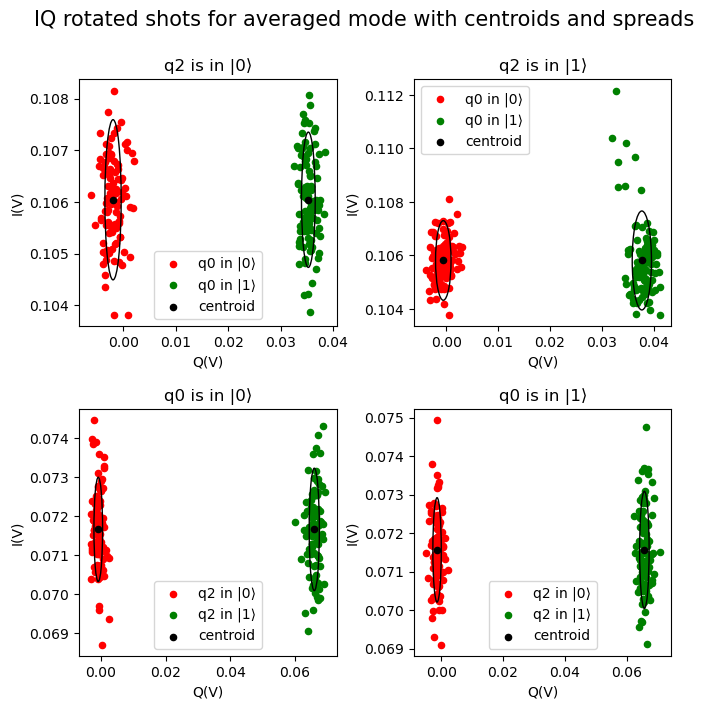

In [180]:
fig, ax = set_figure(suptitle="IQ rotated shots for averaged mode with centroids and spreads")
plot_4graphs(dataset_rotated, ax, "avg")
plot_centroid_and_inertia_4graphs(centroids_q0_rot, inertias_q0, centroids_q2_rot, inertias_q2, ax, "avg")

Single-shot case:

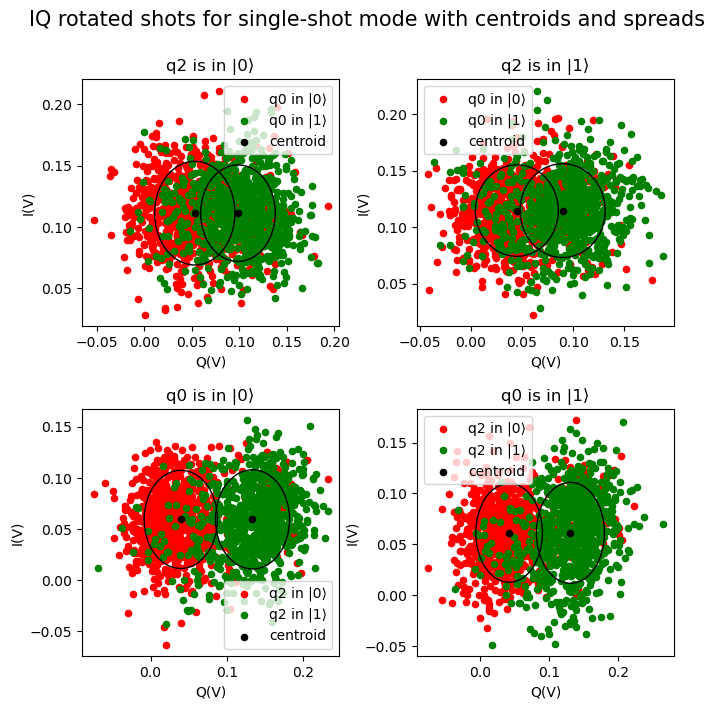

In [149]:
fig, ax = set_figure(suptitle="IQ rotated shots for single-shot mode with centroids and spreads")
plot_4graphs(dataset_rotated, ax, "s-s")
plot_centroid_and_inertia_4graphs(centroids_q0_rot, inertias_q0, centroids_q2_rot, inertias_q2, ax, "s-s")

We see that the blobs are now correctly rotated, notice also (especially in the averaged case) that at this point the points of the same blob have roughly the same Q value, meaning that we chose Q(V) as the usable variable for detection.

## Analysis 3: build the gaussian distributions

Since our intuition is that the voltage noise has mainly a stochastic nature, we will transform each blob in a gaussian distribution, from which we extract mean and standard deviations, basically equivalent variables to center and radius but more precise and useful.

We will later use the means of the blobs to build a simple state detecting program.

We calculate and save the mean relative to each end every blob (divided by qubit):

In [181]:
means_q0 = initialize_2x2dict("avg", "s-s")
means_q2 = initialize_2x2dict("avg", "s-s")

for mode in ["avg", "s-s"]:
    for i in range(2):
        for j in range(2):
            means_q0[mode][i][j] = norm.fit(dataset_rotated[mode][i][j]["y1"])[0]
            means_q2[mode][i][j] = norm.fit(dataset_rotated[mode][i][j]["y3"])[0]

In [182]:
# plots an histogram and corresponding gaussian distribution
def plot_gaussian(data, bins, color, ax):

    ax.hist(data, bins=bins, density=True, alpha=0.6, color=color)
    mu, std = norm.fit(data)
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    ax.plot(x, p, "k")

In [183]:
# plots 4 histograms and pdfs side to side
def plot_4gaussians(mode, bins, dataset):

    ax[0][0].title.set_text("q2 is in |0⟩")
    ax[0][0].set(xlabel="Q(V)", ylabel="Event count")
    plot_gaussian(dataset[mode][0][0]["y1"], bins, "red", ax[0][0])
    plot_gaussian(dataset[mode][1][0]["y1"], bins, "green", ax[0][0])

    ax[0][1].title.set_text("q2 is in |1⟩")
    ax[0][1].set(xlabel="Q(V)", ylabel="Event count")
    plot_gaussian(dataset[mode][0][1]["y1"], bins, "red", ax[0][1])
    plot_gaussian(dataset[mode][1][1]["y1"], bins, "green", ax[0][1])

    ax[1][0].title.set_text("q1 is in |0⟩")
    ax[1][0].set(xlabel="Q(V)", ylabel="Event count")
    plot_gaussian(dataset[mode][0][0]["y3"], bins, "red", ax[1][0])
    plot_gaussian(dataset[mode][0][1]["y3"], bins, "green", ax[1][0])

    ax[1][1].title.set_text("q1 is in |1⟩")
    ax[1][1].set(xlabel="Q(V)", ylabel="Event count")
    plot_gaussian(dataset[mode][1][0]["y3"], bins, "red", ax[1][1])
    plot_gaussian(dataset[mode][1][1]["y3"], bins, "green", ax[1][1])

Now we peek at the distributions and histograms for 10, 50, and 100 bins (the lower the number of bins, the smoother the histogram). As before, red is for ground state, while green is for excited state.

Averaged case:

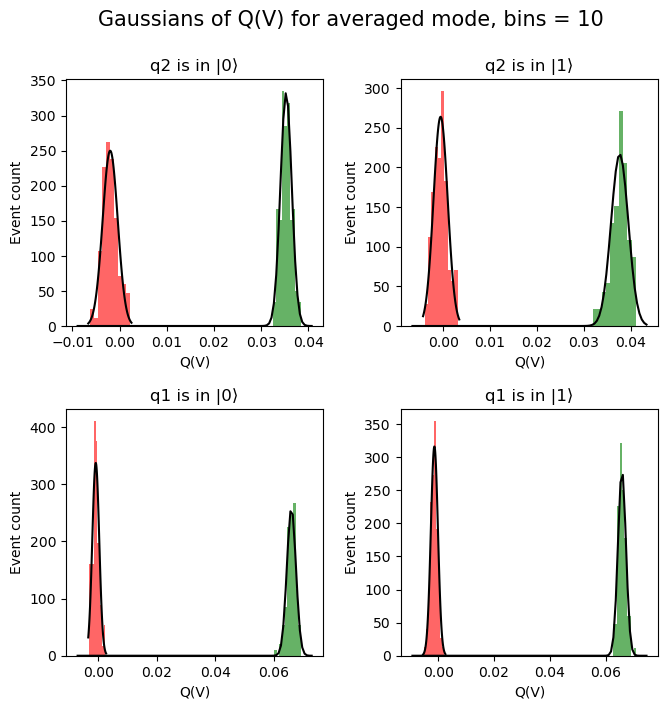

In [184]:
fig, ax = set_figure(suptitle="Gaussians of Q(V) for averaged mode, bins = 10")
plot_4gaussians("avg", 10, dataset_rotated)

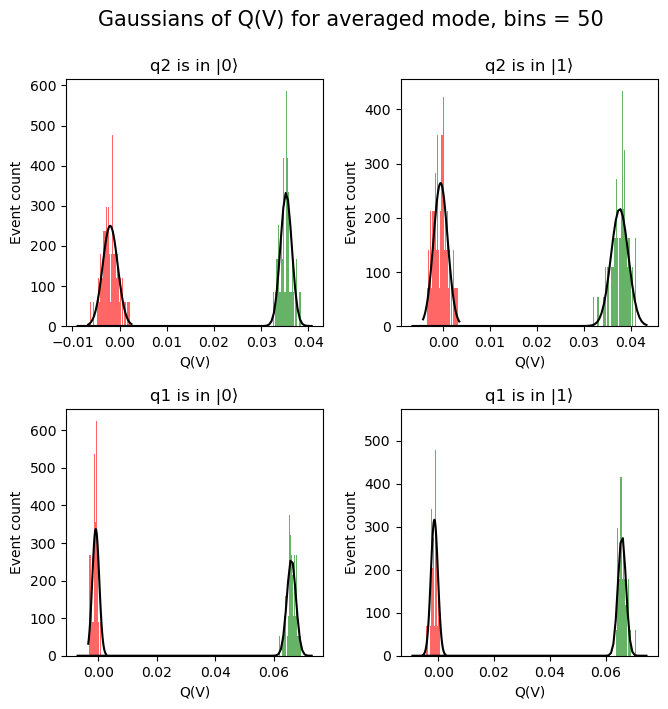

In [185]:
fig, ax = set_figure(suptitle="Gaussians of Q(V) for averaged mode, bins = 50")
plot_4gaussians("avg", 50, dataset_rotated)

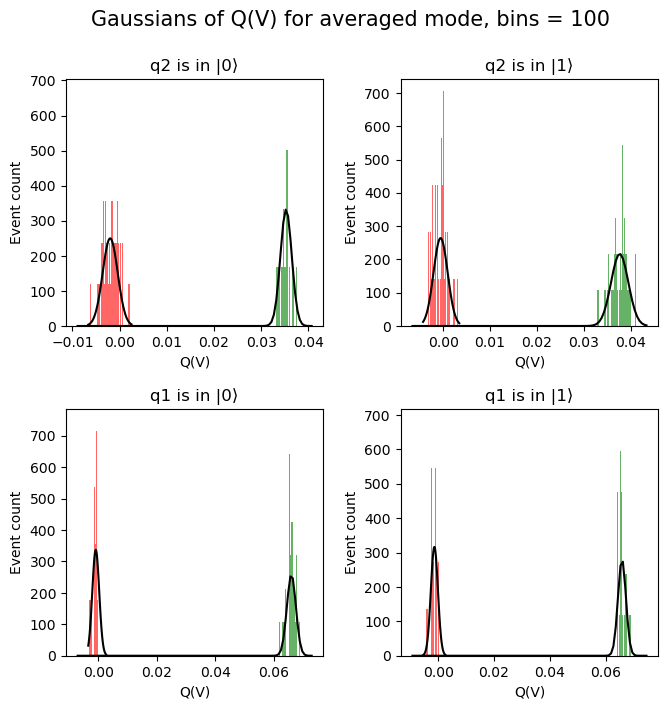

In [186]:
fig, ax = set_figure(suptitle="Gaussians of Q(V) for averaged mode, bins = 100")
plot_4gaussians("avg", 100, dataset_rotated)

Single-shot case:

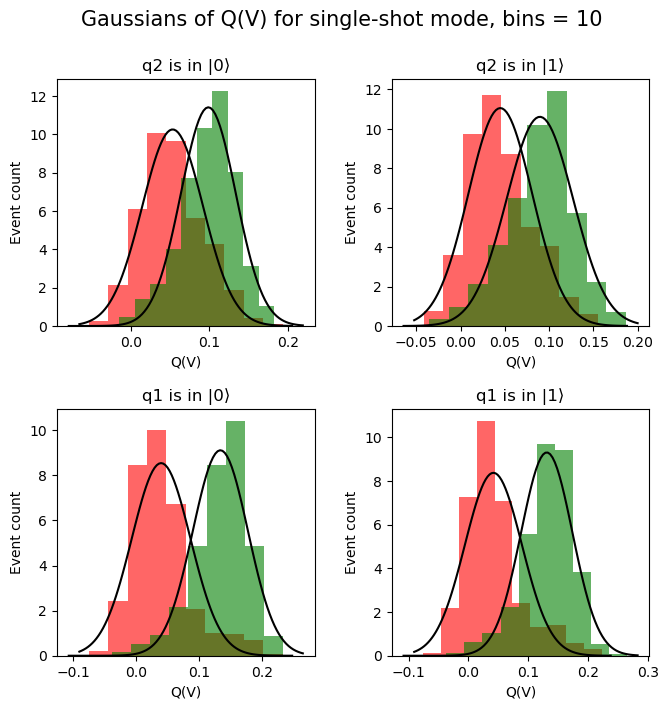

In [187]:
fig, ax = set_figure(suptitle="Gaussians of Q(V) for single-shot mode, bins = 10")
plot_4gaussians("s-s", 10, dataset_rotated)

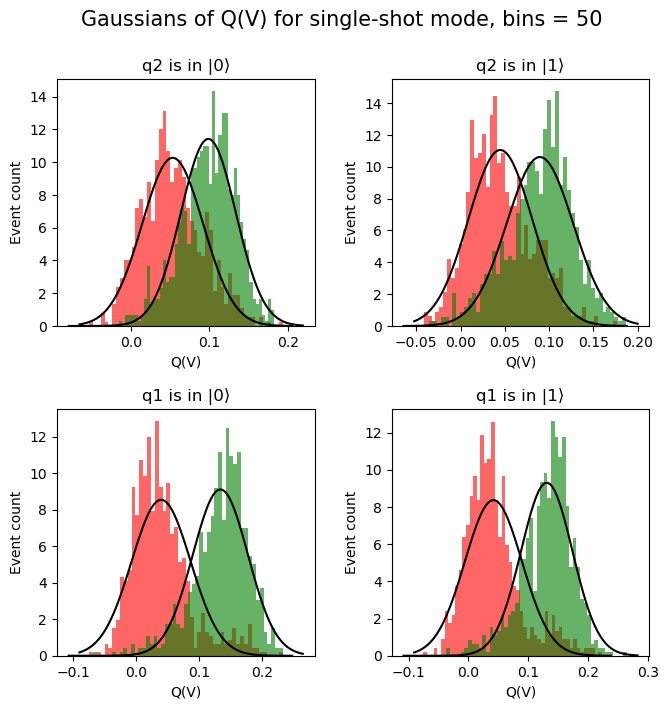

In [188]:
fig, ax = set_figure(suptitle="Gaussians of Q(V) for single-shot mode, bins = 50")
plot_4gaussians("s-s", 50, dataset_rotated)

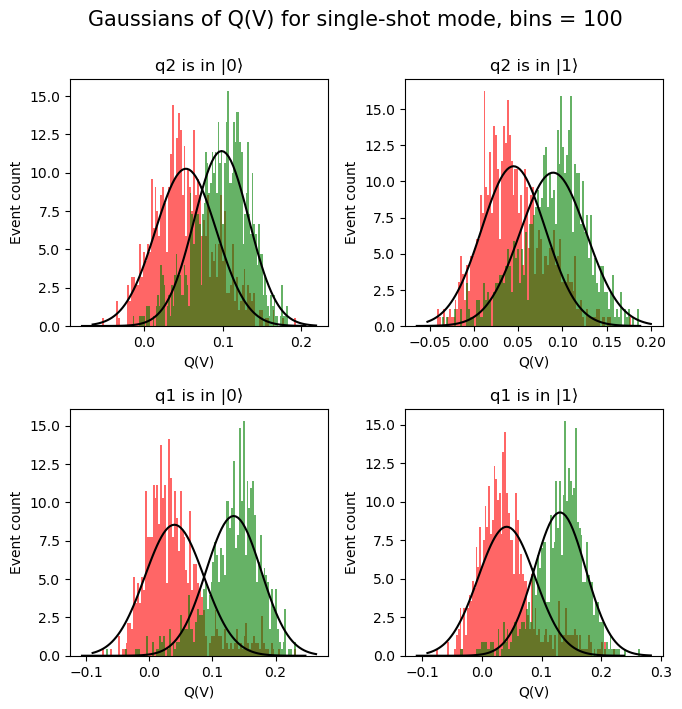

In [189]:
fig, ax = set_figure(suptitle="Gaussians of Q(V) for single-shot mode, bins = 100")
plot_4gaussians("s-s", 100, dataset_rotated)

We can again see the difference in separation between average and single-shot mode.

In single-shot mode the two peaks (means) of the distribution are still rather separated, but the big standard deviation makes their use as state detector less reliable and potentially harmful to the detector accuracy.

## Analysis 4: design and calibrate a simple state detector
In this final section, we build a simple state detecting program, which has the aim to correctly classify any output voltage, guessing what is the state in wich the investigated qubit is.

To do this, we take the investigated voltage and find its distance from the means of the two gaussians that represent the ground and excited states; then we assign the measurement to the state of the closest of the two means.

### 4.1 Detector design

In [158]:
# detects the closest mean, so the closest state
def detect_state(voltage, mu_0, mu_1):

    d0 = abs(voltage - mu_0)
    d1 = abs(voltage - mu_1)
    
    if (d0 < d1):
        return 0
    
    else: return 1

### 4.2 Probability Matrices

Now that we have a way to assign each voltage to a state, we want to measure the effectiveness of the detector; basically, we measure the probability to give the correct result (knowing beforehand in what state the qubit was actually prepared, and comparing it to the detector decision).

The visualization of accuracy of the detector will be carried on using **confusion matrices**, in which we show the number of guessed states vs the actual prepared states (in probability terms, so between 0 and 1).

In [190]:
# counts the number of correctly classifed states
def extract_count_vector(voltages, target, mu_0, mu_1):

    count = 0
    for v in voltages:
        if detect_state(v, mu_0, mu_1) == target:
            count += 1
            
    return count

In [192]:
# builds the probability (confusion) matrix (warning: also very ugly)
def build_proba_matrix(dataset, selected_qubit, means, fixed_state):

    count_qubit_in_0 = initialize_2x2dict("avg", "s-s")
    count_qubit_in_1 = initialize_2x2dict("avg", "s-s")

    for mode in ["avg","s-s"]:
        for i in range(2):
            for j in range(2):
                
                if selected_qubit == 0:
                    count_qubit_in_0[mode][i][j] = extract_count_vector(dataset[mode][i][j]["y1"], target=0, mu_0=means[mode][0][fixed_state], mu_1=means[mode][1][fixed_state])
                    count_qubit_in_1[mode][i][j] = extract_count_vector(dataset[mode][i][j]["y1"], target=1, mu_0=means[mode][0][fixed_state], mu_1=means[mode][1][fixed_state])

                elif selected_qubit == 2:
                    count_qubit_in_0[mode][i][j] = extract_count_vector(dataset[mode][i][j]["y3"], target=0, mu_0=means[mode][fixed_state][0], mu_1=means[mode][fixed_state][1])
                    count_qubit_in_1[mode][i][j] = extract_count_vector(dataset[mode][i][j]["y3"], target=1, mu_0=means[mode][fixed_state][0], mu_1=means[mode][fixed_state][1]) 

                else: raise ValueError 
    
    matrix = initialize_2x2dict("avg", "s-s")
    for mode,divider in zip(["avg","s-s"], [101,760]):

        if selected_qubit == 0:
            matrix[mode][0][0] = count_qubit_in_0[mode][0][fixed_state] / divider
            matrix[mode][0][1] = count_qubit_in_0[mode][1][fixed_state] / divider
            matrix[mode][1][0] = count_qubit_in_1[mode][0][fixed_state] / divider
            matrix[mode][1][1] = count_qubit_in_1[mode][1][fixed_state] / divider


        if selected_qubit == 2:
            matrix[mode][0][0] = count_qubit_in_0[mode][fixed_state][0] / divider
            matrix[mode][0][1] = count_qubit_in_0[mode][fixed_state][1] / divider
            matrix[mode][1][0] = count_qubit_in_1[mode][fixed_state][0] / divider
            matrix[mode][1][1] = count_qubit_in_1[mode][fixed_state][1] / divider

    return matrix

In [195]:
# plots a confusion matrix
def plot_proba_matrix(matrix, ax):
    
    df_cm = pd.DataFrame(matrix, index = ["|0⟩","|1⟩"], columns = ["|0⟩","|1⟩"])
    sn.heatmap(df_cm, annot=True, ax=ax)

In [194]:
# plots the usual 4 subplots
def plot_4matrices(dataset, means_q0, means_q2, ax, mode):

    ax[0][0].title.set_text("Qubit 0 while fixing qubit 2 to |0⟩")
    plot_proba_matrix(build_proba_matrix(dataset, 0, means_q0, 0)[mode], ax=ax[0][0])
    ax[0][0].set(xlabel="Prepared state", ylabel="Measured state")

    ax[0][1].title.set_text("Qubit 0 while fixing qubit 2 to |1⟩")
    plot_proba_matrix(build_proba_matrix(dataset, 0, means_q0, 1)[mode], ax=ax[0][1])
    ax[0][1].set(xlabel="Prepared state", ylabel="Measured state")

    ax[1][0].title.set_text("Qubit 2 while fixing qubit 1 to |0⟩")
    plot_proba_matrix(build_proba_matrix(dataset, 2, means_q2, 0)[mode], ax=ax[1][0])
    ax[1][0].set(xlabel="Prepared state", ylabel="Measured state")

    ax[1][1].title.set_text("Qubit 2 while fixing qubit 1 to |1⟩")
    plot_proba_matrix(build_proba_matrix(dataset, 2, means_q2, 1)[mode], ax=ax[1][1])
    ax[1][1].set(xlabel="Prepared state", ylabel="Measured state")

We can finally take a look at the confusion matrices for all the possible configurations.

Averaged case:

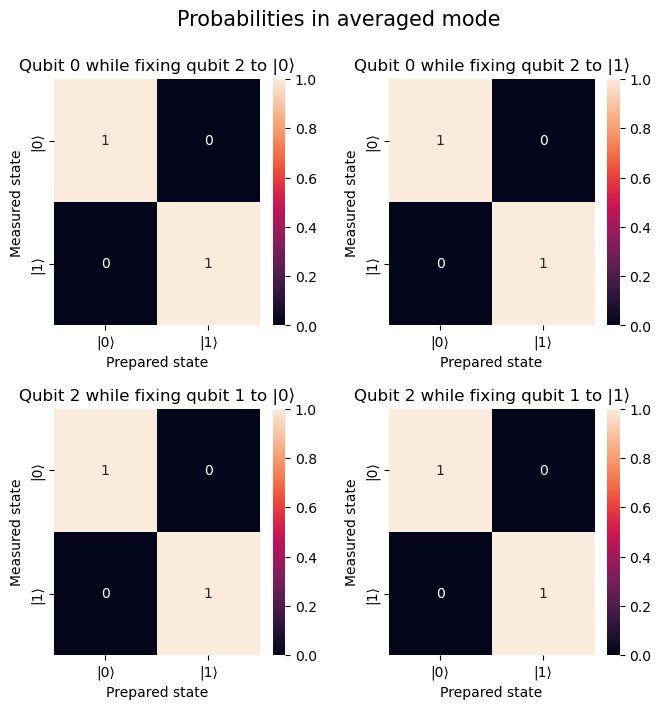

In [164]:
fig, ax = set_figure(suptitle="Probabilities in averaged mode")
plot_4matrices(dataset_rotated, means_q0, means_q2, ax, "avg")

Single-shot case:

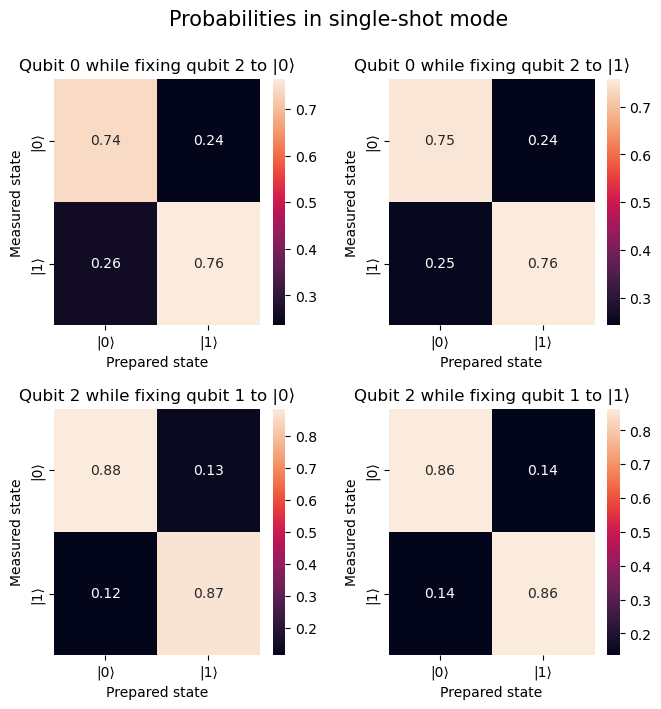

In [165]:
fig, ax = set_figure(suptitle="Probabilities in single-shot mode")
plot_4matrices(dataset_rotated, means_q0, means_q2, ax, "s-s")

## Final Conclusions

From the confusion matrices we can conclude that, when using parameters learned from averaged shots, even a simple detector is capable of excellent performances (in our case 100% accuracy).

Of course in real life taking a lot of measurements (avg mode requires roughly 100 times more shots than single) is extensively time and energy consuming; the single shots matrices show us that even with a lot rougher data a good accuracy is certainly achievable, and, perhaps in concomitance with better detecting programs (e.g. machine learning) and quantum correction methods, a fast and reliable qubit detection is behind the corner.